In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [64]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [65]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros

In [66]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol','Cryptocurrency'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,82,TCP,2.9595,103.6315,135.19425,6709.539,184.327,0.0,407,1266,...,443,5355.0,80.0,3.0,5.0,5.75,84.0,160.0,248.0,not_mine


# Preprocesamiento

### Imputación de valores ausentes

In [67]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [68]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [69]:
dataCopyA = dataA
dataA.shape

(4733, 28)

In [70]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [71]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

### OneHotEncoder

In [72]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x6 sparse matrix of type '<class 'numpy.float64'>'
	with 7966 stored elements in Compressed Sparse Row format>

In [73]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine
0,0,0,1,0,0,1
3,0,0,1,0,1,0


In [75]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [76]:
y = dataA['Type_mine']
X = dataA.drop(['Type_mine','Type_not_mine'],axis = 1)

### Holdout

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [78]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [79]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 2
Número de nodos terminales: 3


[Text(223.2, 453.0, 'first_sp <= 1887.5\nsamples = 2788\nvalue = [1229, 1559]\nclass = i'),
 Text(111.6, 271.8, 'samples = 1214\nvalue = [1214, 0]\nclass = T'),
 Text(334.79999999999995, 271.8, 'First_Protocol_TCP <= 0.5\nsamples = 1574\nvalue = [15, 1559]\nclass = i'),
 Text(223.2, 90.59999999999997, 'samples = 15\nvalue = [15, 0]\nclass = T'),
 Text(446.4, 90.59999999999997, 'samples = 1559\nvalue = [0, 1559]\nclass = i')]

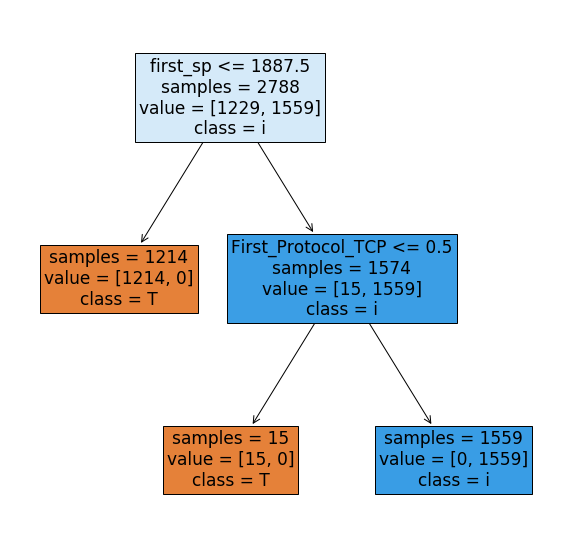

In [80]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [81]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([1, 0, 1, ..., 1, 1, 1], dtype=uint8)

In [82]:
len(y_pred[y_pred == 0])

522

In [83]:
len(y_pred[y_pred == 1])

673

### Métricas y matriz de confusión

Matriz de confusión


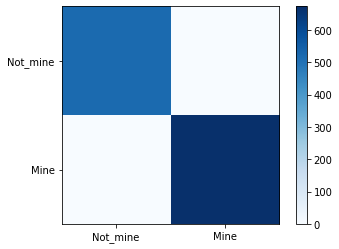

In [84]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [85]:
pd.DataFrame(churm)

,0,1
0,522,0
1,0,673


In [86]:
metricas(y_test, y_pred, churm)

Exactitud:  1.0
Kappa:  1.0
Metricas de los registros mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0
Metricas de los registros no mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0


# Experimento 1

In [87]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [88]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

In [93]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


Netflows          0
First_Protocol    0
p1_d              0
p2_d              0
p3_d              0
duration          0
max_d             0
min_d             0
#packets          0
Avg_bps           0
Avg_pps           0
Avg_bpp           0
#Bytes            0
#sp               0
#dp               0
first_sp          0
second_sp         0
third_sp          0
first_dp          0
second_dp         0
third_dp          0
p1_ip             0
p2_ip             0
p3_ip             0
p1_ib             0
p2_ib             0
p3_ib             0
Type              0
dtype: int64

### Imputar valores

In [91]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [92]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

In [ ]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

In [ ]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

In [ ]:
y = dataA['Type_mine']
X = dataA.drop(['Type_mine','Type_not_mine'],axis = 1)

In [96]:
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [ ]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [ ]:
y_pred = model.predict(X)
y_pred

In [ ]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [ ]:
pd.DataFrame(churm)

In [ ]:
metricas(y, y_pred, churm)

# Experimento 2

In [ ]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

In [ ]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#dp', '#packets', '#sp', 'duration', 'first_dp', 'first_sp',
       'max_d', 'min_d', 'p1_d', 'p1_ib', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ib', 'second_dp', 'second_sp', 'third_sp','Type_mine']
print(best_feature_noPure)

In [ ]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

In [ ]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type == "mine"]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

In [ ]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


In [ ]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [ ]:
porcion_minera_conjuntoB = porcion_minera_conjuntoB.rename(columns = {'Type':'Type_mine'})
porcion_minera_conjuntoB['Type_mine'] = porcion_minera_conjuntoB['Type_mine'].replace({'mine':1,'not_mine':0})

In [ ]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature]], axis = 0)
data_final.shape

In [ ]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

In [ ]:
data_final.drop(['index'],axis =1, inplace=True)

In [ ]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [ ]:
data_final.shape

### Modelo

In [ ]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [ ]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


In [ ]:
K_fold = KFold(n_splits = 10)

In [ ]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [ ]:
scores

In [ ]:
churm = matriz_confusion(y.iloc[resultados_test[7]], predicciones[7], plt.cm.OrRd)

In [ ]:
pd.DataFrame(churm)

In [ ]:
metricas(y.iloc[resultados_test[7]], predicciones[7], churm)

### Prueba final

In [ ]:
porcion_no_minera_conjuntoA.columns

In [ ]:
copy_porcion_minera_conjuntoB.columns

In [ ]:
prueba_final.shape

In [ ]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [ ]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA,dataB], axis = 0)

In [ ]:
bestFeature = ['#dp', '#packets', '#sp', 'duration', 'first_dp',
       'first_sp', 'max_d', 'min_d', 'p1_d', 'p1_ib', 'p1_ip', 'p2_d',
       'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'second_dp', 'second_sp',
       'third_sp']

In [ ]:
X_p = prueba_final[bestFeature]
y_p = prueba_final['Type'].replace({'mine':1,'not_mine':0})

In [ ]:
y_pred_proba = modelos[0].predict(X_p)

In [ ]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [ ]:
pd.DataFrame(churm)

In [ ]:
metricas(y_p, y_pred_proba, churm)

In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_proba[:,1]

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

In [ ]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [ ]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

In [ ]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas